In [1]:
!pip install bert-score
!pip install pythainlp
!pip install rouge
!pip install attacut

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 80.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.8/473.8 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=8f7216b1babfcbc99fed3f51ce78ba9c69a61a4179378cc7fb8a212b658954ab
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=d14a5d7579761104060a84c6df975d92d6d7fad267e01c02cd434fdbe0cf4b2e
  Stored in directory: /root/.cach

In [2]:
from bert_score import score
from pythainlp.tokenize import word_tokenize
from rouge import Rouge
from tqdm import tqdm
import pandas as pd
import numpy as np
import re

def calculate_bert_score(candidate, reference):
    P, R, F1 = score([candidate], [reference], lang='th', verbose=False)
    bert_score = {
        'precision': float(P[0]),
        'recall': float(R[0]),
        'f1': float(F1[0])
    }
    return bert_score

In [3]:
def calculate_rouge(candidate, reference, engine=None):
    if engine:
        hypothesis_tokenized = ' '.join(word_tokenize(candidate, engine=engine))
        reference_tokenized = ' '.join(word_tokenize(reference, engine=engine))
    else:  # ใช้ default
        hypothesis_tokenized = ' '.join(word_tokenize(candidate))
        reference_tokenized = ' '.join(word_tokenize(reference))

    rouge = Rouge()
    scores = rouge.get_scores(hypothesis_tokenized, reference_tokenized)[0]

    rouge1_f1 = scores['rouge-1']['f']
    rouge2_f1 = scores['rouge-2']['f']
    rougel_f1 = scores['rouge-l']['f']

    avg_rouge_score = (rouge1_f1 + rouge2_f1 + rougel_f1) / 3

    return rouge1_f1, rouge2_f1, rougel_f1, avg_rouge_score

In [4]:
def get_text_after_colon(text):
    if ':' in text:
        return text.split(':', 1)[1].strip()
    return text

In [5]:
files = [
    ('/content/Gemma2-final-prompt.csv', '/content/Gemma2-final-output.csv'),
    ('/content/LLama3-final-prompt.csv', '/content/LLama3-final-output.csv'),
    ('/content/Qwen2-final-prompt.csv', '/content/Qwen2-final-output.csv')
]

In [54]:
tqdm.pandas()

for input_file, output_file in files:
    df = pd.read_csv(input_file)

    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    df['sum_extractive'] = df['sum_extractive'].apply(get_text_after_colon)
    df['sum_abstractive'] = df['sum_abstractive'].apply(get_text_after_colon)

    bert_scores_extractive = df.progress_apply(
        lambda row: calculate_bert_score(row['sum_extractive'], row['extractive']), axis=1
    )

    df['BERT_precision_extractive'] = bert_scores_extractive.apply(lambda x: x['precision'])
    df['BERT_recall_extractive'] = bert_scores_extractive.apply(lambda x: x['recall'])
    df['BERT_f1_extractive'] = bert_scores_extractive.apply(lambda x: x['f1'])

    rouge_scores_extractive = df.progress_apply(
        lambda row: calculate_rouge(row['sum_extractive'], row['extractive'], engine='attacut'), axis=1
    )

    df['ROUGE_1_extractive'] = rouge_scores_extractive.apply(lambda x: x[0])
    df['ROUGE_2_extractive'] = rouge_scores_extractive.apply(lambda x: x[1])
    df['ROUGE_l_extractive'] = rouge_scores_extractive.apply(lambda x: x[2])
    df['avg_ROUGE_extractive'] = rouge_scores_extractive.apply(lambda x: x[3])

    bert_scores_abstractive = df.progress_apply(
        lambda row: calculate_bert_score(row['sum_abstractive'], row['abstractive']), axis=1
    )

    df['BERT_precision_abstractive'] = bert_scores_abstractive.apply(lambda x: x['precision'])
    df['BERT_recall_abstractive'] = bert_scores_abstractive.apply(lambda x: x['recall'])
    df['BERT_f1_abstractive'] = bert_scores_abstractive.apply(lambda x: x['f1'])

    rouge_scores_abstractive = df.progress_apply(
        lambda row: calculate_rouge(row['sum_abstractive'], row['abstractive'], engine='attacut'), axis=1
    )

    df['ROUGE_1_abstractive'] = rouge_scores_abstractive.apply(lambda x: x[0])
    df['ROUGE_2_abstractive'] = rouge_scores_abstractive.apply(lambda x: x[1])
    df['ROUGE_l_abstractive'] = rouge_scores_abstractive.apply(lambda x: x[2])
    df['avg_ROUGE_abstractive'] = rouge_scores_abstractive.apply(lambda x: x[3])

    df.to_csv(output_file, index=False)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/attacut/models/__init__.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that c

In [55]:
test = pd.read_csv('/content/LLama3-final-output.csv')
test

,content,extractive,abstractive,sum_extractive,sum_abstractive,BERT_precision_extractive,BERT_recall_extractive,BERT_f1_extractive,ROUGE_1_extractive,ROUGE_2_extractive,ROUGE_l_extractive,avg_ROUGE_extractive,BERT_precision_abstractive,BERT_recall_abstractive,BERT_f1_abstractive,ROUGE_1_abstractive,ROUGE_2_abstractive,ROUGE_l_abstractive,avg_ROUGE_abstractive
0,"การระดมทุนในตลาดหุ้นไทยอยู่ที่ประมาณ 500,000 ล...","การระดมทุนในตลาดหุ้นไทยอยู่ที่ประมาณ 500,000 ล...","การระดมทุนในตลาดหุ้นไทยอยู่ที่ประมาณ 500,000 ล...",อย่างไรก็ตาม การระดมทุนในตลาดหุ้นไทยอยู่ที่ประ...,เรื่องที่น่าสนใจเกี่ยวกับการระดมทุนในตลาดหุ้นไ...,0.829751,0.824108,0.826920,0.575540,0.407895,0.539568,0.507668,0.793609,0.798479,0.796037,0.513966,0.378840,0.491620,0.461475
1,ช่วงหลายปีที่ผ่านมา บริษัท ปตท. จำกัด (มหาชน) ...,ปตท. หรือ PTT พยายามสู่ New S-Curve มุ่งธุรกิจ...,ปตท. (PTT) มุ่งธุรกิจนอนออยล์มากขึ้นสู่ New S...,ปตท. จำกัด (มหาชน) หรือ PTT พยายามออกจากกรอบขอ...,\tปตท. จำกัด (มหาชน) หรือ PTT ได้พยายามออกจากก...,0.825765,0.810906,0.818268,0.611296,0.344988,0.538206,0.498163,0.787564,0.793621,0.790581,0.624658,0.315603,0.558904,0.499721
2,พริกกะเหรี่ยง p.singdang60@gmail.com ...,เศรษฐกิจไทยเริ่มฟื้นชัด ส่งออก ท่องเที่ยว ลงทุ...,เศรษฐกิจไทยเริ่มฟื้นชัด ส่งออก ท่องเที่ยว ลงทุ...,เรื่องเศรษฐกิจไทยทิศทางใหม่\nประเทศไทยจะเป็นเจ...,The Thai tourism industry is expected to conti...,0.718835,0.719615,0.719225,0.621212,0.444043,0.595960,0.553738,0.580593,0.548675,0.564183,0.020566,0.000000,0.020566,0.013710
3,นายชาญวิทย์ อนัคกุล ประธานเจ้าหน้าที่บริหาร บร...,นายชาญวิทย์ อนัคกุล ประธานเจ้าหน้าที่บริหาร บร...,นายชาญวิทย์ อนัคกุล ประธานเจ้าหน้าที่บริหาร บร...,aquí\n\nนายชาญวิทย์ อนัคกุล ประธานเจ้าหน้าที่...,โดยนายชาญวิทย์ อนัคกุล ประธานเจ้าหน้าที่บริหาร...,0.805339,0.811308,0.808312,0.693141,0.500000,0.678700,0.623947,0.827558,0.821171,0.824352,0.708333,0.404762,0.666667,0.593254
4,บริษัท โกลบอล เพาเวอร์ ซินเนอร์ยี่ จำกัด (มหาช...,นายชวลิต ทิพพาวนิช ประธานเจ้าหน้าที่บริหารและก...,นายชวลิต ทิพพาวนิช ประธานเจ้าหน้าที่บริหารและก...,ค.ศ. 2564\n ค.ศ. 2564\nบริษัท โกลบอล เพาเวอ...,\tบริษัท โกลบอล เพาเวอร์ ซินเนอร์ยี่ จำกัด (มห...,0.813427,0.809873,0.811646,0.788644,0.629482,0.731861,0.716662,0.863105,0.843301,0.853088,0.709220,0.494172,0.553191,0.585528
5,ทางานเป็นลูกหม้อการประปานครหลวง (กปน.) มาร่วม ...,ทำงานเป็นลูกหม้อการประปานครหลวง (กปน.) มาร่วม ...,ทำงานเป็นลูกหม้อการประปานครหลวง (กปน.) มาร่วม ...,ส่วนแรก : วางแผนการดำเนินงาน\nตั้งแต่วันนี้เป็...,The Bangkok Metropolitan Waterworks Authority ...,0.727224,0.740399,0.733752,0.610811,0.444444,0.551351,0.535536,0.570438,0.545036,0.557448,0.053763,0.020305,0.053763,0.042610
6,กรุงเทพธุรกิจ ปตท.เลื่อนแผนส่งออก LNG เชิงพาณ...,นายวุฒิกร สติฐิต รองกรรมการ ผู้จัดการใหญ่หน่วย...,นายวุฒิกร สติฐิต รองกรรมการ ผู้จัดการใหญ่หน่วย...,\tพตท.เลื่อนแผนส่งออก LNG เชิงพาณิชย์เป็นไตรมา...,ปตท.เลื่อนแผนส่งออก LNG เชิงพาณิชย์เป็นไตร...,0.850035,0.835051,0.842476,0.706714,0.429561,0.692580,0.609618,0.826269,0.850514,0.838216,0.684015,0.443890,0.669145,0.599017
7,ปลดล็อกกับดักปั่นที่พุ่งเว่อร์ สมาคมอ...,สมาคมอสังหาฯชลบุรีเชียร์รัฐเร่งจัดรูปที่ดินหมื...,สมาคมอสังหาฯชลบุรีเชียร์รัฐเร่งจัดรูปที่ดินหมื...,คู่มือการปลดล็อกกับดักปั่นที่พุ่งเว่อร์\nอย่าง...,​ รัฐและเอกชนร่วมมือกันพัฒนาเมืองใหม่ในเข...,0.750685,0.747573,0.749126,0.535385,0.268000,0.375385,0.392923,0.733529,0.728781,0.731148,0.520900,0.245399,0.353698,0.373332
8,ทันหุ้น - GPSC ผลงานโค้งสองสวยรับขายไฟพุ่ง ซดก...,นางสาวสุกิตตี ไชยรักษ์ ผู้จัดการฝ่ายแผนกลยุทธ์...,นางสาวสุกิตตี ไชยรักษ์ ผู้จัดการฝ่ายแผนกลยุทธ์...,สุence\n\nGPSC ผลงานโค้งสองสวยรับขายไฟพุ่ง ซดก...,ปตท. กลุ่มบริษัทไฟฟ้าที่สำคัญในประเทศไทย ประกอ...,0.796293,0.790497,0.793384,0.582090,0.360825,0.417910,0.453608,0.817816,0.822953,0.820376,0.702875,0.423237,0.581470,0.569194
9,ทันหุ้น - โบรกส่อง PTT-PTTEP พื้นฐานยังแกร่ง ม...,นักวิเคราะห์บริษัทหลักทรัพย์ กสิกรไทย จำกัด เผ...,นักวิเคราะห์บริษัทหลักทรัพย์ กสิกรไทย จำกัด เผ...,ทันหุ้น - โบรกส่อง PTT-PTTEP พื้นฐานยังแกร่ง\n...,ผู้ส่องตลาดคาดการณ์ว่า PTT-PTTEP จะมีโอกาสเติบ...,0.802026,0.

### Average

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_paths = [
    '/content/Gemma2-final-output.csv',
    '/content/LLama3-final-output.csv',
    '/content/Qwen2-final-output.csv'
]

columns_to_evaluate = [
    'BERT_precision_extractive',
    'BERT_recall_extractive',
    'BERT_f1_extractive',
    'ROUGE_1_extractive',
    'ROUGE_2_extractive',
    'ROUGE_l_extractive',
    'avg_ROUGE_extractive'
]

def process_file(file_path):
    df = pd.read_csv(file_path)

    indices_to_drop = [0, 16, 5, 7, 11, 13, 15, 18]
    df = df.drop(indices_to_drop)
    avg_scores = df[columns_to_evaluate].mean()

    return avg_scores

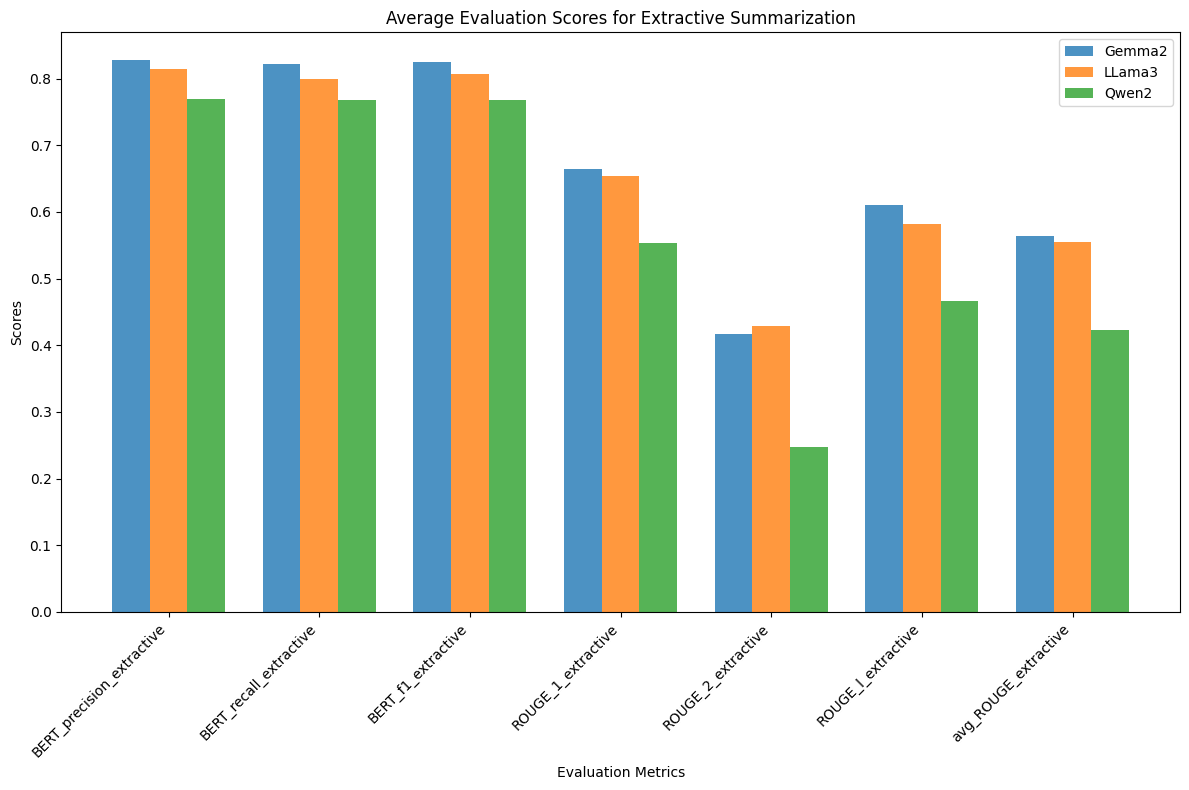


Average Evaluation Scores:
                             Gemma2    LLama3     Qwen2
BERT_precision_extractive  0.828120  0.813993  0.769132
BERT_recall_extractive     0.821516  0.799454  0.767380
BERT_f1_extractive         0.824776  0.806584  0.768229
ROUGE_1_extractive         0.664730  0.653970  0.553967
ROUGE_2_extractive         0.416209  0.428485  0.247781
ROUGE_l_extractive         0.610798  0.582287  0.466264
avg_ROUGE_extractive       0.563912  0.554914  0.422671


In [90]:
# Process all files and store results
results = {}
for file_path in file_paths:
    if os.path.exists(file_path):
        model_name = os.path.basename(file_path).split('-')[0]  # Extract model name from file path
        results[model_name] = process_file(file_path)
    else:
        print(f"Warning: File not found - {file_path}")

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Plotting bar chart
plt.figure(figsize=(12, 8))
bar_width = 0.25
index = range(len(columns_to_evaluate))

for i, model in enumerate(results_df.columns):
    plt.bar([x + i*bar_width for x in index], results_df[model],
            width=bar_width, label=model, alpha=0.8)

plt.xlabel('Evaluation Metrics')
plt.ylabel('Scores')
plt.title('Average Evaluation Scores for Extractive Summarization')
plt.xticks([x + bar_width for x in index], columns_to_evaluate, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Print the results
print("\nAverage Evaluation Scores:")
print(results_df)

In [162]:
file_paths_abs = [
    '/content/Gemma2-final-output.csv',
    '/content/LLama3-final-output.csv',
    '/content/Qwen2-final-output.csv'
]

columns_to_evaluate_abs = [
    'BERT_precision_abstractive',
    'BERT_recall_abstractive',
    'BERT_f1_abstractive',
    'ROUGE_1_abstractive',
    'ROUGE_2_abstractive',
    'ROUGE_l_abstractive',
    'avg_ROUGE_abstractive'
]

def process_file_abs(file_path):
    df = pd.read_csv(file_path)

    indices_to_drop = [0, 2, 3, 4, 5, 7, 10, 11, 13, 15, 16, 18]
    df = df.drop(indices_to_drop)
    avg_scores = df[columns_to_evaluate_abs].mean()

    return avg_scores

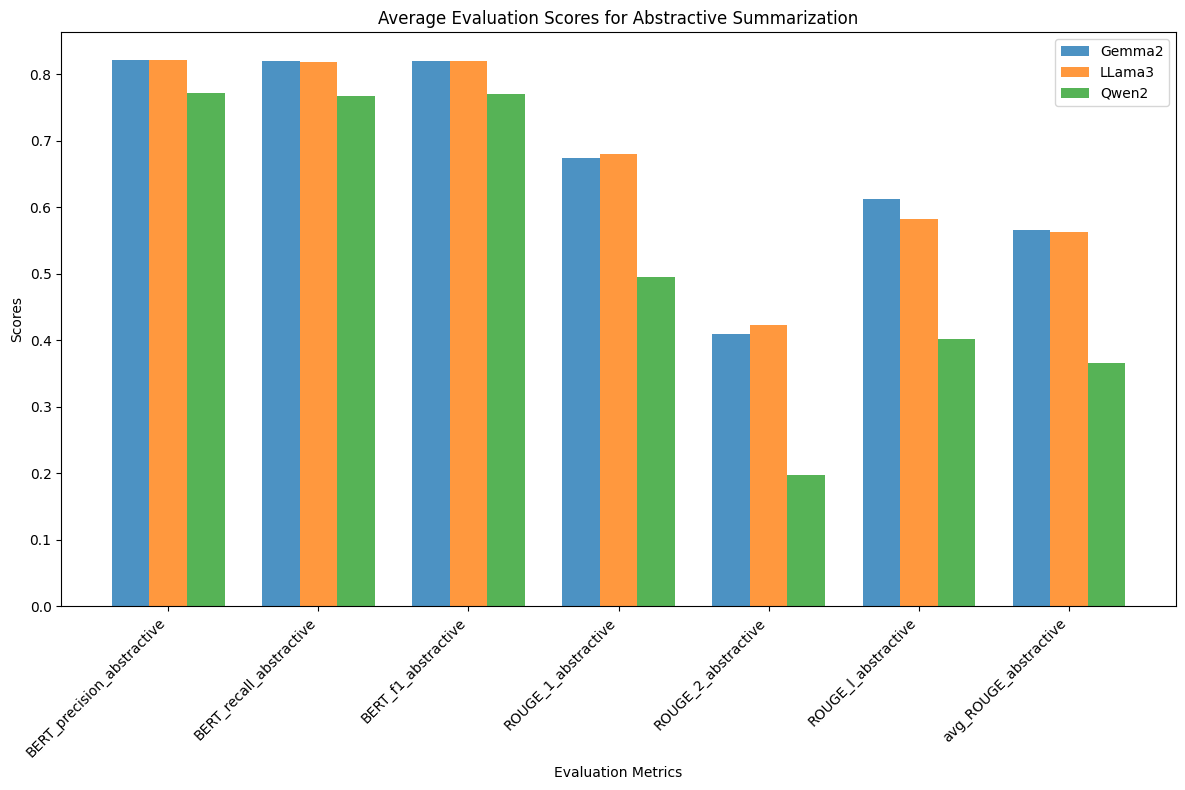


Average Evaluation Scores for Abstractive Summarization:
                              Gemma2    LLama3     Qwen2
BERT_precision_abstractive  0.820826  0.821774  0.771344
BERT_recall_abstractive     0.819432  0.818286  0.767711
BERT_f1_abstractive         0.820105  0.819952  0.769470
ROUGE_1_abstractive         0.674257  0.679831  0.495260
ROUGE_2_abstractive         0.409575  0.423271  0.197289
ROUGE_l_abstractive         0.611947  0.582638  0.402061
avg_ROUGE_abstractive       0.565259  0.561913  0.364870


In [163]:
# Process all files and store results
results_abs = {}
for file_path in file_paths_abs:
    if os.path.exists(file_path):
        model_name = os.path.basename(file_path).split('-')[0]  # Extract model name from file path
        results_abs[model_name] = process_file_abs(file_path)
    else:
        print(f"Warning: File not found - {file_path}")

# Create a DataFrame from the results
results_df_abs = pd.DataFrame(results_abs)

# Plotting bar chart
plt.figure(figsize=(12, 8))
bar_width = 0.25
index = range(len(columns_to_evaluate_abs))

for i, model in enumerate(results_df_abs.columns):
    plt.bar([x + i*bar_width for x in index], results_df_abs[model],
            width=bar_width, label=model, alpha=0.8)

plt.xlabel('Evaluation Metrics')
plt.ylabel('Scores')
plt.title('Average Evaluation Scores for Abstractive Summarization')
plt.xticks([x + bar_width for x in index], columns_to_evaluate_abs, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Print the results
print("\nAverage Evaluation Scores for Abstractive Summarization:")
print(results_df_abs)